<a href="https://colab.research.google.com/github/Information-Theory-Group/Experiments/blob/vaibhavi/TopPSamplerWithEntropy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!pip install -U datasets
!pip install transformers

In [21]:
import transformers

transformers.logging.set_verbosity_info() #run this for logs

In [22]:
import torch
import torch.nn.functional as F
# import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM

class TopKSamplerWithEntropy:
    def __init__(self, model, tokenizer, k=10, max_length=50, device="cpu"):
        self.model = model.to(device)
        self.tokenizer = tokenizer
        self.k = k
        self.max_length = max_length
        self.device = device

    def compute_entropy(self, probs):
        return -torch.sum(probs * probs.log(), dim=-1).item()

    def compute_layerwise_entropy(self, hidden_states):
        """
        hidden_states: tuple of [layer_i] each of shape [1, seq_len, hidden_dim]
        Returns: list of entropy values, one per layer (on the last token)
        """
        entropies = []
        for layer in hidden_states:
            last_token_vec = layer[0, -1, :]
            probs = F.softmax(last_token_vec, dim=-1)
            entropy = self.compute_entropy(probs)
            entropies.append(entropy)
        return entropies

    def sample(self, prompt):
        input_ids = self.tokenizer.encode(prompt, return_tensors="pt").to(self.device)
        output_ids = input_ids.clone()

        output_entropies = []
        layerwise_entropies = []

        for _ in range(self.max_length):
            with torch.no_grad():
                outputs = self.model(output_ids, output_hidden_states=True)
                logits = outputs.logits[:, -1, :]
                probs = F.softmax(logits, dim=-1)

                # Output entropy
                entropy = self.compute_entropy(probs)
                output_entropies.append(entropy)

                # Layerwise entropy
                hidden_states = outputs.hidden_states  # tuple of layers
                layer_entropies = self.compute_layerwise_entropy(hidden_states)
                layerwise_entropies.append(layer_entropies)

                # Top-k sampling
                topk_probs, topk_indices = torch.topk(probs, self.k, dim=-1)
                topk_probs = topk_probs / topk_probs.sum(dim=-1, keepdim=True)
                next_token = torch.multinomial(topk_probs, num_samples=1)
                next_token_id = topk_indices.gather(-1, next_token)

                output_ids = torch.cat([output_ids, next_token_id], dim=-1)

        generated_text = self.tokenizer.decode(output_ids[0], skip_special_tokens=True)
        return generated_text, output_entropies, layerwise_entropies


In [23]:
class TopPSamplerWithEntropy:
    def __init__(self, model, tokenizer, p=0.9, max_length=50, device="cpu"):
        self.model = model.to(device)
        self.tokenizer = tokenizer
        self.p = p
        self.max_length = max_length
        self.device = device

    def compute_entropy(self, probs):
        return -torch.sum(probs * probs.log(), dim=-1).item()

    def compute_layerwise_entropy(self, hidden_states):
        """
        hidden_states: tuple of [layer_i] each of shape [1, seq_len, hidden_dim]
        Returns: list of entropy values, one per layer (on the last token)
        """
        entropies = []
        for layer in hidden_states:
            last_token_vec = layer[0, -1, :]
            probs = F.softmax(last_token_vec, dim=-1)
            entropy = self.compute_entropy(probs)
            entropies.append(entropy)
        return entropies

    def sample(self, prompt):
        input_ids = self.tokenizer.encode(prompt, return_tensors="pt").to(self.device)
        output_ids = input_ids.clone()

        output_entropies = []
        layerwise_entropies = []

        for _ in range(self.max_length):
            with torch.no_grad():
                outputs = self.model(output_ids, output_hidden_states=True)
                logits = outputs.logits[:, -1, :]
                probs = F.softmax(logits, dim=-1)

                # Output entropy
                entropy = self.compute_entropy(probs)
                output_entropies.append(entropy)

                # Layerwise entropy
                hidden_states = outputs.hidden_states  # tuple of layers
                layer_entropies = self.compute_layerwise_entropy(hidden_states)
                layerwise_entropies.append(layer_entropies)

                # Top-p sampling

                sorted_probs, sorted_indices = torch.sort(probs, descending=True)
                cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
                # cumulative_probs = torch.cumsum(torch.nn.functional.softmax(sorted_probs, dim=-1), dim=-1)

                sorted_indices_to_keep = cumulative_probs <= self.p

                sorted_indices_to_keep[..., 0] = True

                mask = sorted_indices_to_keep.scatter(dim=1, index=sorted_indices, src=sorted_indices_to_keep)
                logits[~mask] = float('-inf')

                # next_token = torch.multinomial(sorted_probs[sorted_indices_to_keep], num_samples=1)

                probs = torch.nn.functional.softmax(logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)

                next_token_id = sorted_indices_to_keep.gather(-1, next_token)

                # topp_probs, topp_indices = torch.topp(probs, self.k, dim=-1)
                # topk_probs = topk_probs / topk_probs.sum(dim=-1, keepdim=True)
                # next_token = torch.multinomial(topk_probs, num_samples=1)
                # next_token_id = topk_indices.gather(-1, next_token)

                output_ids = torch.cat([output_ids, next_token_id], dim=-1)

        generated_text = self.tokenizer.decode(output_ids[0], skip_special_tokens=True)
        return generated_text, output_entropies, layerwise_entropies


In [24]:
from datasets import load_dataset

dataset = load_dataset("gsm8k", "main", split="train[:1]")
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2")

sampler = TopPSamplerWithEntropy(model, tokenizer, p=0.8, max_length=30)

for i, example in enumerate(dataset):
    prompt = example["question"]
    print(f"\nPrompt {i + 1}: {prompt}")

    generated, output_entropies, layerwise_entropies = sampler.sample(prompt)

    print("Generated:", generated)
    print("Output Entropies:", output_entropies)
    print("Layerwise Entropies per step:")
    for step, layer_ent in enumerate(layerwise_entropies):
        print(f"Step {step+1}: {layer_ent}")


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--gpt2/snapshots/607a30d783dfa663caf39e06633721c8d4cfcd7e/config.json
Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.52.4",
  "use_cach


Prompt 1: Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?
Generated: Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?!!!!"!"!"!"!!!""""""!!!!!!"!!!
Output Entropies: [4.613718509674072, 4.264997959136963, 4.781734466552734, 5.257657527923584, 5.294293403625488, 4.158212184906006, 6.313697814941406, 6.591004371643066, 5.727200031280518, 4.793657302856445, 3.057405471801758, 3.39353609085083, 1.4451338052749634, 1.4399417638778687, 2.010533332824707, 1.878906011581421, 1.5962681770324707, 1.5347585678100586, 1.9127275943756104, 1.8184529542922974, 1.072655439376831, 0.7007701992988586, 0.5525709390640259, 0.6194510459899902, 0.8409057259559631, 1.2113286256790161, 1.6459691524505615, 2.684325695037842, 1.3410066366195679, 1.25550377368927]
Layerwise Entropies per step:
Step 1

In [25]:
import matplotlib.pyplot as plt

def plot_output_entropy(entropies, title="Output Token Entropy"):
    plt.figure(figsize=(8, 4))
    plt.plot(entropies, marker='o', color='royalblue')
    plt.title(title)
    plt.xlabel("Generated Token Step")
    plt.ylabel("Entropy")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

import seaborn as sns
import numpy as np

def plot_layerwise_entropy(layerwise_entropies, title="Layerwise Entropy Heatmap"):
    entropy_array = np.array(layerwise_entropies)
    plt.figure(figsize=(12, 6))
    sns.heatmap(entropy_array.T, cmap="viridis", cbar=True, xticklabels=True)
    plt.title(title)
    plt.xlabel("Generated Token Step")
    plt.ylabel("Layer")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


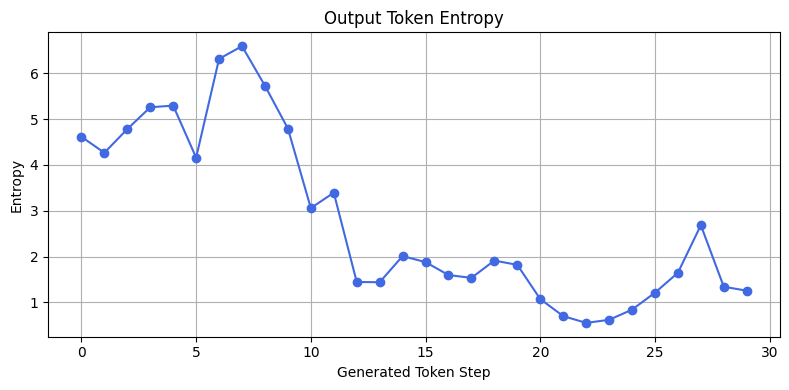

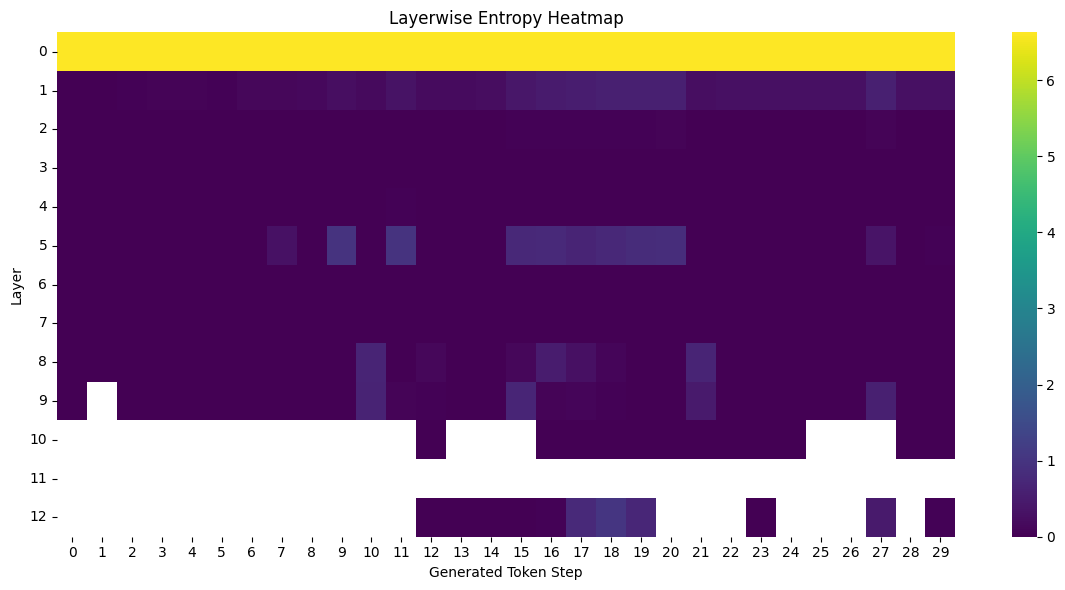

In [26]:
plot_output_entropy(output_entropies)
plot_layerwise_entropy(layerwise_entropies)